In [ ]:
# Required Imports
import pandas as pd
import numpy as np
import cv2
from glob import glob
import librosa
from google.colab import drive

from tensorflow.keras import optimizers, models, layers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from random import sample

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/Chords'

In [ ]:
y, sr = librosa.load('/content/drive/MyDrive/Chords/Major/Major_5.wav')

In [ ]:
Path_for_Major_Spectogram = '/content/drive/MyDrive/Image_Folder/Major'

In [ ]:
# Converting Audio files for Major chords into Spectograms
MajorAudioFiles = glob('/content/drive/MyDrive/Chords/Major/*.wav')
for file in MajorAudioFiles:
  y, sr = librosa.load(file)
  D = librosa.stft(y)
  S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max)
  ImageAudio = (S_db * 255).astype(np.uint8)
  idx = file.rfind("/")
  filename = file[idx+1:]
  cv2.imwrite(Path_for_Major_Spectogram+"/"+filename+".png",ImageAudio)

In [ ]:
Path_for_Minor_Spectogram = '/content/drive/MyDrive/Image_Folder/Minor'

In [ ]:
# Converting Audio files for Minor chords into Spectograms
MinorAudioFiles = glob('/content/drive/MyDrive/Chords/Minor/*.wav')
for file in MinorAudioFiles:
  y, sr = librosa.load(file)
  D = librosa.stft(y)
  S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max)
  ImageAudio = (S_db * 255).astype(np.uint8)
  idx = file.rfind("/")
  filename = file[idx+1:]
  cv2.imwrite(Path_for_Minor_Spectogram+"/"+filename+".png",ImageAudio)

In [ ]:
# For moving into train, test and valid

# Define the paths
base_path = '/content/drive/My Drive/Image_Folder'
major_path = os.path.join(base_path, 'Major')
minor_path = os.path.join(base_path, 'Minor')
destination_base_path = '/content/drive/My Drive/Image_Folder'

# Create train, valid, test folders and their subfolders
for subset in ['train', 'valid', 'test']:
    for category in ['Major', 'Minor']:
        folder_path = os.path.join(destination_base_path, subset, category)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

# Function to move a specific number of files
def move_files(src_folder, dest_folder, num_files):
    all_files = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f))]
    selected_files = sample(all_files, num_files)
    for filename in selected_files:
        src_file = os.path.join(src_folder, filename)
        dest_file = os.path.join(dest_folder, filename)
        shutil.move(src_file, dest_file)

# Move files from Major
move_files(major_path, os.path.join(destination_base_path, 'train', 'Major'), 200)
move_files(major_path, os.path.join(destination_base_path, 'valid', 'Major'), 50)
move_files(major_path, os.path.join(destination_base_path, 'test', 'Major'), 10)

# Move files from Minor
move_files(minor_path, os.path.join(destination_base_path, 'train', 'Minor'), 200)
move_files(minor_path, os.path.join(destination_base_path, 'valid', 'Minor'), 50)
move_files(minor_path, os.path.join(destination_base_path, 'test', 'Minor'), 10)

In [ ]:
# Define paths
train_path = '/content/drive/My Drive/Image_Folder/train'
valid_path = '/content/drive/My Drive/Image_Folder/valid'
test_path = '/content/drive/My Drive/Image_Folder/test'

# Create the data generators
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['Major', 'Minor'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Major', 'Minor'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['Major', 'Minor'], batch_size=10, shuffle=False)

print(f'Found {train_batches.samples} training images belonging to {train_batches.num_classes} classes.')
print(f'Found {valid_batches.samples} validation images belonging to {valid_batches.num_classes} classes.')
print(f'Found {test_batches.samples} test images belonging to {test_batches.num_classes} classes.')

# Model Definition
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate steps_per_epoch and validation_steps
steps_per_epoch = train_batches.samples // train_batches.batch_size
validation_steps = valid_batches.samples // valid_batches.batch_size

print(f'Steps per epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

# Adding .repeat() to ensure data generator does not run out of data
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_batches,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )
).repeat()

valid_dataset = tf.data.Dataset.from_generator(
    lambda: valid_batches,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )
).repeat()

# Train the model using the dataset
model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_dataset,
    validation_steps=validation_steps,
    epochs=10,
    verbose=2
)


Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 400 training images belonging to 2 classes.
Found 100 validation images belonging to 2 classes.
Found 20 test images belonging to 2 classes.
Steps per epoch: 40
Validation steps: 10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
40/40 - 92s - 2s/step - accuracy: 0.4650 - loss: 38.6968 - val_accuracy: 0.5400 - val_loss: 18.9158
Epoch 2/10
40/40 - 36s - 907ms/step - accuracy: 0.7575 - loss: 3.5347 - val_accuracy: 0.5900 - val_loss: 5.7851
Epoch 3/10
40/40 - 36s - 906ms/step - accuracy: 0.8700 - loss: 1.3046 - val_accuracy: 0.5800 - val_loss: 5.0656
Epoch 4/10
40/40 - 38s - 959ms/step - accuracy: 0.9575 - loss: 0.2459 - val_accuracy: 0.5500 - val_loss: 5.9770
Epoch 5/10
40/40 - 38s - 961ms/step - accuracy: 0.9700 - loss: 0.2034 - val_accuracy: 0.5300 - val_loss: 5.8590
Epoch 6/10
40/40 - 37s - 917ms/step - accuracy: 0.9900 - loss: 0.0590 - val_accuracy: 0.5800 - val_loss: 6.1860
Epoch 7/10
40/40 - 37s - 928ms/step - accuracy: 0.9875 - loss: 0.0737 - val_accuracy: 0.5200 - val_loss: 5.8688
Epoch 8/10
40/40 - 39s - 963ms/step - accuracy: 0.9925 - loss: 0.0781 - val_accuracy: 0.5600 - val_loss: 6.3764
Epoch 9/10
40/40 - 37s - 917ms/step - accuracy: 0.9750 - loss: 0.1525 - val_accuracy: 0.5500 - val_loss: 

In [ ]:
model.save('Major_Minor.keras')

In [ ]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
np.round(predictions)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
test_batches.class_indices

{'Major': 0, 'Minor': 1}

In [ ]:
# plot_confusion_matrix() function from sklearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4 6]
 [1 9]]


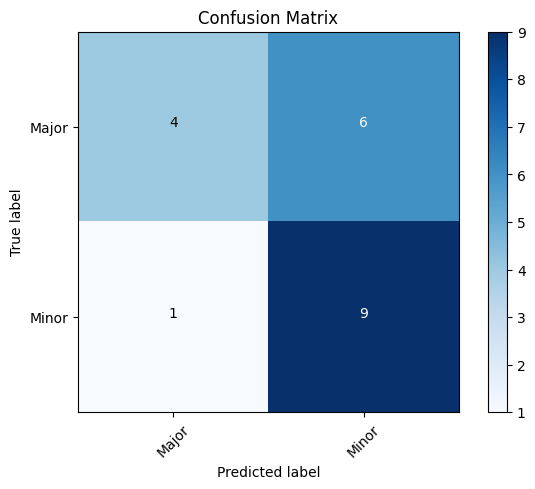

In [ ]:
cm_plot_labels = ['Major','Minor']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
